## Test Dataloader for LigityScore 3D


In [1]:
import pandas as pd
import numpy  as np
import math

import torch
from sbvscnnmsc.sbvsHelper import loadDataFrame

from torch.utils.data import Dataset, DataLoader

In [2]:
class datasets:
    def __init__(self):
        self.Train = None
        self.Validation = None
        self.Test = None
        

In [3]:
def minmax(x, verbose=0):

    x_max = np.max(x)
    x_min = np.min(x)
    
    if verbose:
        print ("Max Value: %f" % x_max)
        print ("Min Value: %f" % x_min)
        
    if x_max == x_min:
        if verbose:
            print ("Divide by 0")
        xx = x
        return xx

    xx = (x - x_min) / (x_max - x_min)
    
    return xx

In [37]:
def myrotate3D(x, index):
    
    """
    Function to Rotate 3D Matrix by 90 degrees. Only certain positions are allowed as the Matrix has 
    two sides equal, but the third is of different size. Example 98x98x54.
    
    Rotations along the X axis: 0, 90, 180, 270 (0 is the starting point)
    Rotations along the Y axis: 180
    Rotations along the Z axis: 270
    
    Arguments:
        x (np.array): 3D input matrix
        index (int) : Integer to specify rotation
                            0 --> X, 0   degrees
                            1 --> X, 90  degrees
                            2 --> X, 180 degrees
                            3 --> X, 270 degrees
                            4 --> Y, 180 degress
                            5 --> Z, 270 degrees
    Return:
        x_r: rotated matrix based on index
    
    """
    
    x_rot = [0, 1, 2, 3]   # rotations along the X axis: 0, 90, 180, 270 degrees
    y_rot = [2]            # rotations along the Y axis: 180 degrees
    z_rot = [2]            # rotations along the Z axis: 180 degrees
       
    # Create List of possible 90 degree rotations
    rot_index = x_rot + y_rot + z_rot
    
    # Create List of axis labels for possible 90 degree rotations
    rot_axis = list("x"*len(x_rot)) + list("y"*len(y_rot)) + list("z"*len(z_rot))
    
    # Define Dictionary for plane
    rot_dict = {"x":(0,1), "y":(0,2), "z":(1,2)}
    
    # Rotate by 90 degrees based on index provided
    #x_r = np.rot90(x, i, (0,1))
    #x_r = np.rot90(x, i, (0,2))
    #x_r = np.rot90(x, i, (1,2))
    x_r = np.rot90(x, rot_index[index], rot_dict[rot_axis[index]]).copy()
    #print (x_r)
        
    return x_r
    

In [38]:
###############################################
#    Pytorch Dataset Definition - Ligity
###############################################
"""
    pdbCode year 	realAffinity 	pdbSplit 	pdbPath 	                                            dataAvail 	features 	split
0 	3zzf 	2012 	0.40 	        general 	./pdbbind/v2016/data/general-set-except-refined/3zzf 	None 	    None 	    NaN
1 	3gww 	2009 	0.45 	        general 	./pdbbind/v2016/data/general-set-except-refined/3gww 	None 	    None 	    NaN
"""

class PDBdatasetLigity(Dataset):
    """PDB Bind Dataset"""

    def __init__(self, pdb_df, newShape = (160, 140, 20), dataColumn="features", targetColumn="realAffinity", pdbIDColumn="pdbCode", convModule=2, R=False, rot_index = 0):
        # grids=True, grid_resolution=1.0, max_dist = 10.0, R=0):
        
        """
        Arguments:
            pdb_df  (DataFrame): Pandas DataFrame Object containing PDB Features.
            dataColumn (string): Pandas Series column index that containes a list element, that in turn includes matrix of features
                      to represent features for all atoms in P-L complex.
            targetColumn (string):
            pdbIDColumn (string):
        """
        #self.grids = grids
        #self.grid_resolution = grid_resolution
        #self.max_dist = max_dist   
        self.targets = pdb_df[targetColumn]
        self.data  = pdb_df[dataColumn]         # data is a pandas series object
        self.pdbID = pdb_df[pdbIDColumn]
        self.newShape = newShape
        self.convModule = convModule
        self.R = R
        self.rot_index = rot_index
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        # initialize return value
        r = []
        
        
        sample = self.data.iloc[idx]      # numpy array
        t = self.targets.iloc[idx]
        ID = self.pdbID.iloc[idx]
        
        # Check for Any NaN values
        if np.isnan(sample).any():
            print ("NaN Detected")
            raise ValueError("Data input contains NaN values.")
               
        # Min-Max Scalar
        sample = minmax(sample, verbose=0)
        
        #reshape to make it image-like
        sample = np.reshape(sample, self.newShape, order='C')
        #print (sample.shape)
        
        # Rotate Matrix
        if self.R: # Rotations are enabled. num_rotations == 6
            sample = myrotate3D(sample, self.rot_index)
            #print ("Rotation with index %d" % self.rot_index)
            #print (sample.shape)
            
  
        # reorder dimension for Conv3D. Input size for Conv3D is (N,Cin,D,H,W)
        #print (sample.shape)                # (X, Y, Cin)
        sample = np.swapaxes(sample, 0, 1)  # (Y, X, Cin) -> Swap Cin with Y 
        #print (sample.shape)
        sample = np.swapaxes(sample, 1, 2)  # (Y, Cin, X) -> Swap Cin with X
        sample = np.swapaxes(sample, 0, 1)  # (Cin, Y, X) -> Swap Cin with X 
        #print (sample.shape)
            
        if self.convModule == 3:
            sample = sample[np.newaxis, ...]
            
            
        r.append(sample)
        r.append(t)
        r.append(ID)
            
            
        return r

In [39]:
splitSets   = {"tr":"Train", "v":"Validation", "t":"Test"}
splitSets   = {"t":"Test"}

input_dir= "/home/joseph/msc/dissertation/myscripts/Ligity_Output/split-uint8"
#input_dir= "../LigityScore_Output/Ligity3D1-0/"


In [40]:
# load datasets
dataset = datasets()
print ("\n\n*********** Load Datasets ...\n")
for i, Set in enumerate(splitSets):
    file = splitSets[Set] + "-pkl"
    setattr(dataset, splitSets[Set], loadDataFrame(input_dir, file) ) # load dataframe. #use setattr from class.



*********** Load Datasets ...


DataFrame loaded from /home/joseph/msc/dissertation/myscripts/Ligity_Output/split-uint8/Test-pkl.zip.



In [41]:
#test
"""
dataset = datasets()
filename = "PDB2016-Lig-Features-x20"

dataset.Train = loadDataFrame(input_dir, filename)
"""

'\ndataset = datasets()\nfilename = "PDB2016-Lig-Features-x20"\n\ndataset.Train = loadDataFrame(input_dir, filename)\n'

In [42]:
dataset.Test.head()

index pdbCode  year realAffinity pdbSplit  \
121    126    3ao4  2011         2.07     core   
131    136    3gv9  2009         2.12     core   
172    177    1uto  2004         2.27     core   
175    180    1ps3  2003         2.28     core   
180    185    4ddk  2013         2.29     core   

                                   pdbPath dataAvail  \
121  ./pdbbind/v2016/data/refined-set/3ao4      True   
131  ./pdbbind/v2016/data/refined-set/3gv9      True   
172  ./pdbbind/v2016/data/refined-set/1uto      True   
175  ./pdbbind/v2016/data/refined-set/1ps3      True   
180  ./pdbbind/v2016/data/refined-set/4ddk      True   

                                              features split  
121  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  test  
131  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  test  
172  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  test  
175  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  test  
180  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  test

In [43]:
dataset.Test.groupby('dataAvail').count()

index  pdbCode  year  realAffinity  pdbSplit  pdbPath  features  \
dataAvail                                                                    
True         280      280   280           280       280      280       280   

           split  
dataAvail         
True         280

In [44]:
dataset.Test = dataset.Test[dataset.Test['dataAvail'] == True]

In [45]:
dataset.Test['features'] = dataset.Test['features'].apply(lambda x: x.astype('float32'))

In [46]:
dataset.Test.head()

index pdbCode  year realAffinity pdbSplit  \
121    126    3ao4  2011         2.07     core   
131    136    3gv9  2009         2.12     core   
172    177    1uto  2004         2.27     core   
175    180    1ps3  2003         2.28     core   
180    185    4ddk  2013         2.29     core   

                                   pdbPath dataAvail  \
121  ./pdbbind/v2016/data/refined-set/3ao4      True   
131  ./pdbbind/v2016/data/refined-set/3gv9      True   
172  ./pdbbind/v2016/data/refined-set/1uto      True   
175  ./pdbbind/v2016/data/refined-set/1ps3      True   
180  ./pdbbind/v2016/data/refined-set/4ddk      True   

                                              features split  
121  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  test  
131  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  test  
172  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  test  
175  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  test  
180  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  test

In [47]:
type(dataset.Test.loc[121,"features"])
x = dataset.Test.loc[121,"features"]
x = torch.tensor(x)
print(x.shape)
x = x.view(160, 140, 20)
print(x.shape)

torch.Size([1120, 20, 20])
torch.Size([160, 140, 20])


In [ ]:
y = [[[1, 1, math.nan], [1, 1, 1], [1, 1, 1], [1, 1, 1]],
    [[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
    [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]]
#y = [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]],
#    [[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
#    [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]]
#y = torch.tensor(y)
y = np.asarray(y)
if not (y==y).all():
    print ("NaN Detected")
else:
    print ("No NaN values")
    
if np.isnan(y).any():
    print ("NaN Detected")
else:
    print ("No NaN values")

In [ ]:

print(y.shape)
print (y)
y = y.view(3, 2, 6)
print(y.shape)
print (y)

In [58]:
# Load Data using pytorch dataloader
batchSize = 2

cnnInput = PDBdatasetLigity (dataset.Test, newShape=(80, 80, 70) , convModule=3, R=True, rot_index=5)
dataloader = DataLoader(cnnInput, batch_size=batchSize, shuffle=True, num_workers=4) #set num_workers to 4 https://pytorch.org/docs/stable/data.html

In [59]:
print("iter | Feature Dimension\t\t | Target Dimension  | PDBCode ")
print("---------------------------------------------------------------------- ")
for i_batch, sample_batched in enumerate(dataloader):
    # sample_batched is a list that includes the features (sample_batched[0]) and the labels (sample_batched[1])
    #print (i_batch)
    sample_batched[1] = [(lambda x: float(x))(x) for x in sample_batched[1]]
    sample_batched[1] = torch.tensor(sample_batched[1])
    print("%4d %34s %19d %10d" % (i_batch, str(sample_batched[0].size()), len(sample_batched[1]), len(sample_batched[2])))
    #print ("%s" % type(sample_batched[0]))
    #print ("%s" % type(sample_batched[1]))
    
    
    
    if i_batch == 1:
        h = sample_batched[0]
        print ("\nPDB Real Affinity from DataLoader (targets):\n %s" % str(sample_batched[1]))
        print ("\nPDB Codes from DataLoader:\n %s" % str(sample_batched[2]))
        

iter | Feature Dimension		 | Target Dimension  | PDBCode 
---------------------------------------------------------------------- 
   0     torch.Size([2, 1, 70, 80, 80])                   2          2
   1     torch.Size([2, 1, 70, 80, 80])                   2          2

PDB Real Affinity from DataLoader (targets):
 tensor([4.6500, 6.8000])

PDB Codes from DataLoader:
 ('4w9c', '1p1n')
   2     torch.Size([2, 1, 70, 80, 80])                   2          2
   3     torch.Size([2, 1, 70, 80, 80])                   2          2
   4     torch.Size([2, 1, 70, 80, 80])                   2          2
   5     torch.Size([2, 1, 70, 80, 80])                   2          2
   6     torch.Size([2, 1, 70, 80, 80])                   2          2
   7     torch.Size([2, 1, 70, 80, 80])                   2          2
   8     torch.Size([2, 1, 70, 80, 80])                   2          2
   9     torch.Size([2, 1, 70, 80, 80])                   2          2
  10     torch.Size([2, 1, 70, 80, 80])   

 124     torch.Size([2, 1, 70, 80, 80])                   2          2
 125     torch.Size([2, 1, 70, 80, 80])                   2          2
 126     torch.Size([2, 1, 70, 80, 80])                   2          2
 127     torch.Size([2, 1, 70, 80, 80])                   2          2
 128     torch.Size([2, 1, 70, 80, 80])                   2          2
 129     torch.Size([2, 1, 70, 80, 80])                   2          2
 130     torch.Size([2, 1, 70, 80, 80])                   2          2
 131     torch.Size([2, 1, 70, 80, 80])                   2          2
 132     torch.Size([2, 1, 70, 80, 80])                   2          2
 133     torch.Size([2, 1, 70, 80, 80])                   2          2
 134     torch.Size([2, 1, 70, 80, 80])                   2          2
 135     torch.Size([2, 1, 70, 80, 80])                   2          2
 136     torch.Size([2, 1, 70, 80, 80])                   2          2
 137     torch.Size([2, 1, 70, 80, 80])                   2          2
 138  

## Feature Sample Scaling and Normalisation

In [70]:
dataset.Test['features'] = dataset.Test['features'].apply(lambda x: x.astype('float32'))

In [90]:
sample = dataset.Test.loc[175,"features"]

In [91]:
type((sample))

numpy.ndarray

In [92]:
print(sample.ravel().shape);

(448000,)


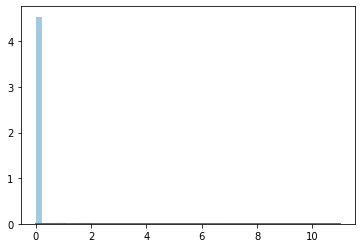

In [93]:
sns.distplot(sample.ravel());

In [15]:
def minmax(x, verbose=0):

    x_max = np.max(x)
    x_min = np.min(x)
    
    if verbose:
        print ("Max Value: %f" % x_max)
        print ("Min Value: %f" % x_min)
        
    if x_max == x_min:
        if verbose:
            print ("Divide by 0")
        xx = x
        return xx

    xx = (x - x_min) / (x_max - x_min)
    
    return xx

In [16]:
def standardNorm(x, verbose=0):

    x_mean = np.mean(x.ravel())
    x_std = np.std(x.ravel())
    
    if verbose:
        print ("Mean Value: %f" % x_mean)
        print ("Sdt  Value: %f" % x_std)
        
    if x_std == 0:
        if verbose:
            print ("Divide by 0")
        xx = x
        return xx

    xx = (x - x_mean) / (x_std)
    
    return xx

In [121]:
sss = standardNorm (sample)

Mean Value: 0.001480
Sdt  Value: 0.071402


In [103]:
ss = minmax(sample)

Max Value: 11.000000
Min Value: 0.000000


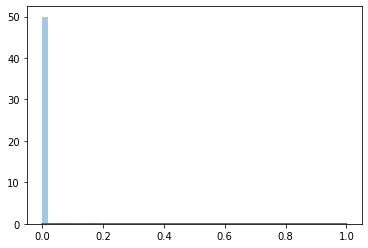

In [104]:
sns.distplot(ss.ravel());

## Test Scaling and Normalisation

In [32]:
import seaborn as sns

In [ ]:
#Use np.ravel (for a 1D view) or np.flatten (for a 1D copy) or np.flat (for an 1D iterator):

In [124]:
y = [[[0, 0, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1]],
    [[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
    [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 33]]]

In [125]:
y = np.asarray(y)

In [126]:
print (y)

[[[ 0  0  0]
  [ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]]

 [[ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]]

 [[ 3  3  3]
  [ 3  3  3]
  [ 3  3  3]
  [ 3  3 33]]]


In [127]:
y_max = np.max(y)
y_min = np.min(y)

print ("Max Value: %f" % y_max)
print ("Min Value: %f" % y_min)

Max Value: 33.000000
Min Value: 0.000000


In [129]:
yy = minmax(y)

Max Value: 33.000000
Min Value: 0.000000


In [130]:
print (yy)

[[[0.         0.         0.        ]
  [0.03030303 0.03030303 0.03030303]
  [0.03030303 0.03030303 0.03030303]
  [0.03030303 0.03030303 0.03030303]]

 [[0.06060606 0.06060606 0.06060606]
  [0.06060606 0.06060606 0.06060606]
  [0.06060606 0.06060606 0.06060606]
  [0.06060606 0.06060606 0.06060606]]

 [[0.09090909 0.09090909 0.09090909]
  [0.09090909 0.09090909 0.09090909]
  [0.09090909 0.09090909 0.09090909]
  [0.09090909 0.09090909 1.        ]]]


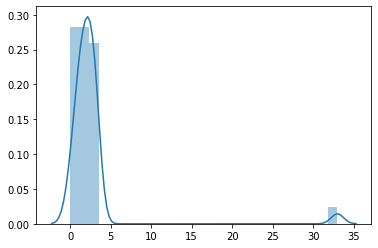

In [131]:
sns.distplot(y.ravel());

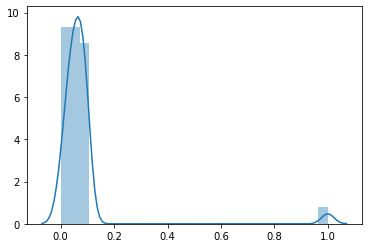

In [132]:
sns.distplot(yy.ravel());

In [133]:
yyy = standardNorm (y)

Mean Value: 2.750000
Sdt  Value: 5.198157


In [134]:
print (yyy)

[[[-0.52903368 -0.52903368 -0.52903368]
  [-0.3366578  -0.3366578  -0.3366578 ]
  [-0.3366578  -0.3366578  -0.3366578 ]
  [-0.3366578  -0.3366578  -0.3366578 ]]

 [[-0.14428191 -0.14428191 -0.14428191]
  [-0.14428191 -0.14428191 -0.14428191]
  [-0.14428191 -0.14428191 -0.14428191]
  [-0.14428191 -0.14428191 -0.14428191]]

 [[ 0.04809397  0.04809397  0.04809397]
  [ 0.04809397  0.04809397  0.04809397]
  [ 0.04809397  0.04809397  0.04809397]
  [ 0.04809397  0.04809397  5.81937052]]]


## Test Overflow of Uint

In [16]:
testnp = np.zeros ((10, 10), dtype='uint8')

In [26]:
print (testnp)

[[ 22 255  44 246   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


In [19]:
testnp[0][0] = 22

In [21]:
testnp[0][1] = 255

In [23]:
testnp[0][2] = 300

In [25]:
testnp[0][3] = -10

## Test 3D Rotations

In [14]:
m = np.arange(8)
print(m)
print (m.shape)

[0 1 2 3 4 5 6 7]
(8,)


#### 2D Model

In [18]:
l = np.arange(4)
l = l.reshape((2,2))
print (l)

[[0 1]
 [2 3]]


In [28]:
np.rot90(l, -1, (0,1))

array([[2, 0],
       [3, 1]])

#### 3D Model

In [30]:
m = np.arange(8)
m = m.reshape((2,2,2))
print(m)
print (m.shape)

[[[0 1]
  [2 3]]

 [[4 5]
  [6 7]]]
(2, 2, 2)


In [31]:
# Rotate an array by 90 degrees in the plane specified by axes
np.rot90(m, 1, (0,1))

array([[[2, 3],
        [6, 7]],

       [[0, 1],
        [4, 5]]])

In [20]:
m = np.arange(12)
print(m)
print (m.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
(12,)


In [21]:
m = m.reshape((2,2,3))
print(m)
print (m.shape)

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]
(2, 2, 3)


In [39]:
x_rot = [0, 1, 2, 3]
y_rot = [0, 2]
#z_rot = [0, 1, 2, 3]
z_rot = [0, 2]


In [36]:

# Rotate Around the X-Axis
for i in x_rot:
    mm = np.rot90(m, i, (0,1))
    print (mm.shape)
    print (mm, "\n")

(2, 2, 3)
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]] 

(2, 2, 3)
[[[ 3  4  5]
  [ 9 10 11]]

 [[ 0  1  2]
  [ 6  7  8]]] 

(2, 2, 3)
[[[ 9 10 11]
  [ 6  7  8]]

 [[ 3  4  5]
  [ 0  1  2]]] 

(2, 2, 3)
[[[ 6  7  8]
  [ 0  1  2]]

 [[ 9 10 11]
  [ 3  4  5]]] 



In [37]:
for i in y_rot:
    mm = np.rot90(m, i, (0,2))
    print (mm.shape)
    print (mm, "\n")

(2, 2, 3)
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]] 

(2, 2, 3)
[[[ 8  7  6]
  [11 10  9]]

 [[ 2  1  0]
  [ 5  4  3]]] 



In [40]:
for i in z_rot:
    mm = np.rot90(m, i, (1,2))
    print (mm.shape)
    print (mm, "\n")

(2, 2, 3)
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]] 

(2, 2, 3)
[[[ 5  4  3]
  [ 2  1  0]]

 [[11 10  9]
  [ 8  7  6]]] 



In [ ]:
#include two dictionaries that contain the {rotationIndex: mutiplier}, and {rotationIndex: planeTuple}

In [24]:
def myrotate3D(x, index):
    
    """
    Function to Rotate 3D Matrix by 90 degrees. Only certain positions are allowed as the Matrix has 
    two sides equal, but the third is of different size. Example 98x98x54.
    
    Rotations along the X axis: 0, 90, 180, 270 (0 is the starting point)
    Rotations along the Y axis: 180
    Rotations along the Z axis: 270
    
    Arguments:
        x (np.array): 3D input matrix
        index (int) : Integer to specify rotation
                            0 --> X, 0   degrees
                            1 --> X, 90  degrees
                            2 --> X, 180 degrees
                            3 --> X, 270 degrees
                            4 --> Y, 180 degress
                            5 --> Z, 270 degrees
    Return:
        x_r: rotated matrix based on index
    
    """
    
    x_rot = [0, 1, 2, 3]   # rotations along the X axis: 0, 90, 180, 270 degrees
    y_rot = [2]            # rotations along the Y axis: 180 degrees
    z_rot = [2]            # rotations along the Z axis: 180 degrees
       
    # Create List of possible 90 degree rotations
    rot_index = x_rot + y_rot + z_rot
    
    # Create List of axis labels for possible 90 degree rotations
    rot_axis = list("x"*len(x_rot)) + list("y"*len(y_rot)) + list("z"*len(z_rot))
    
    # Define Dictionary for plane
    rot_dict = {"x":(0,1), "y":(0,2), "z":(1,2)}
    
    # Rotate by 90 degrees based on index provided
    #x_r = np.rot90(x, i, (0,1))
    #x_r = np.rot90(x, i, (0,2))
    #x_r = np.rot90(x, i, (1,2))
    x_r = np.rot90(x, rot_index[index], rot_dict[rot_axis[index]])
    print (x_r.shape)
        
    return x_r
    
    
    

In [27]:
m = np.ones ((80, 80, 70))

In [36]:
myrotate3D(m, 0)

(80, 80, 70)


array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [69]:
x_rot = [0, 1, 2, 3]   # rotations along the X axis: 0, 90, 180, 270 degrees
y_rot = [2]            # rotations along the Y axis: 180 degrees
z_rot = [2]            # rotations along the Z axis: 180 degrees

print(type(x_rot))

rot_index = x_rot + y_rot + z_rot
#rot_index.append(y_rot)
#rot_index.append(z_rot)

<class 'list'>


In [80]:
aa = ("x"*4,"y"*2)

In [81]:
aa

('xxxx', 'yy')

In [82]:
list(aa)

['xxxx', 'yy']

In [50]:
rot_dict = {0:(0,1), 1:(0,1), 2:(0,1), 3:(0,1), 2:(0,2)}

In [53]:
rot_dict[2]

(0, 2)

In [54]:
x = (9,8)

In [55]:
l = [x *4]

In [56]:
l

[(9, 8, 9, 8, 9, 8, 9, 8)]